In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# License: MIT
# June 2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data[:, :2]  # Take only the first two features
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [5]:
print(f'Training accuracy: {clf.score(X_train, y_train):.4f}')
print(f'Test accuracy: {clf.score(X_test, y_test):.4f}')

Training accuracy: 0.9554
Test accuracy: 0.6579


In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_boundaries(clf, X, y, feature_names, class_labels, ax=None, legend='auto'):
    """Plot the decision boundaries of a classifier along with the dataset points.

    Parameters:
    - clf: The trained classifier
    - X: Feature dataset
    - y: Target labels
    - feature_names: List of feature names for labeling the axes
    - class_labels: List of class labels for coloring the points
    - ax: Matplotlib Axes object where the plot is drawn. If None, uses current axis.
    - legend: Controls the drawing of the legend. Use False to disable the legend.
    """
    if ax is None:
        ax = plt.gca()
        
    # Define colors and markers
    colors = ['red', 'cyan', 'blue']
    markers = ['s', 'o', '^']
    cmap = ListedColormap(colors[:len(class_labels)])
      
    # Setup mesh grid parameters
    resolution = 250  # Number of sample points in each axis
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1     
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), 
                         np.linspace(y_min, y_max, resolution))
    
    # Classify each point in the mesh grid
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape) 
    
    # Generate contour plot
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.4)    
    
    # Plot the training points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=class_labels[y], style=class_labels[y], 
                    hue_order=class_labels, style_order=class_labels,
                    palette=colors, markers=markers, edgecolor='k', ax=ax, legend=legend)

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])    

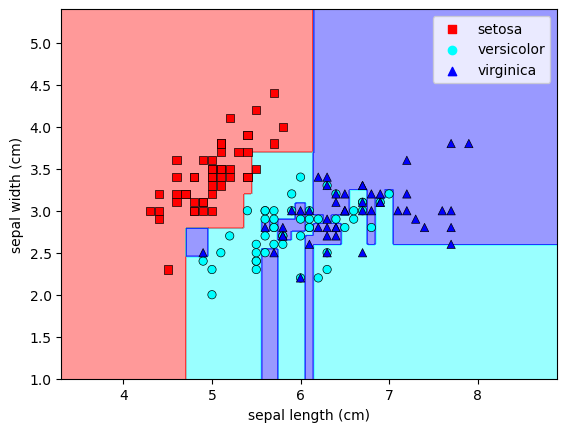

In [7]:
plot_decision_boundaries(clf, X, y, iris.feature_names[:2], iris.target_names)
plt.savefig('figures/iris_decision_tree_boundaries.pdf')

Pre-Pruning

In [8]:
clf_pruned = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [9]:
print(f'Training accuracy: {clf_pruned.score(X_train, y_train):.4f}')
print(f'Test accuracy: {clf_pruned.score(X_test, y_test):.4f}')

Training accuracy: 0.8214
Test accuracy: 0.7632


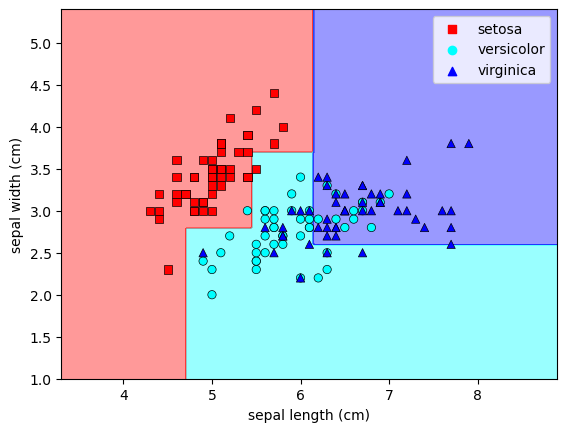

In [10]:
plot_decision_boundaries(clf_pruned, X, y, iris.feature_names[:2], iris.target_names)
plt.savefig('figures/iris_pruned_decision_tree_boundaries.pdf')

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],  # Criteria for choosing nodes
    'max_depth': np.arange(1, 11),   # Depths from 1 to 10
    'min_samples_split': np.arange(2, 11),  # Minimum samples to split a node
    'min_impurity_decrease': np.arange(0.0, 0.5, 0.05)  # Ranges for impurity decrease
}
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_impurity_decrease': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [12]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_impurity_decrease': 0.0,
 'min_samples_split': 2}

Decision Tree Visualization

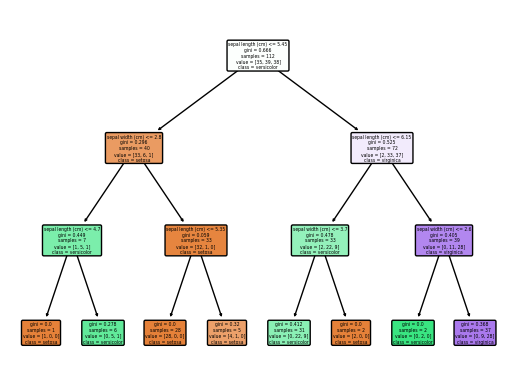

In [13]:
from sklearn import tree

tree.plot_tree(clf_pruned, feature_names=iris.feature_names[:2], 
               class_names=iris.target_names, filled=True, rounded=True)
plt.savefig('figures/iris_pruned_decision_tree.pdf', bbox_inches='tight')

Post-Pruning

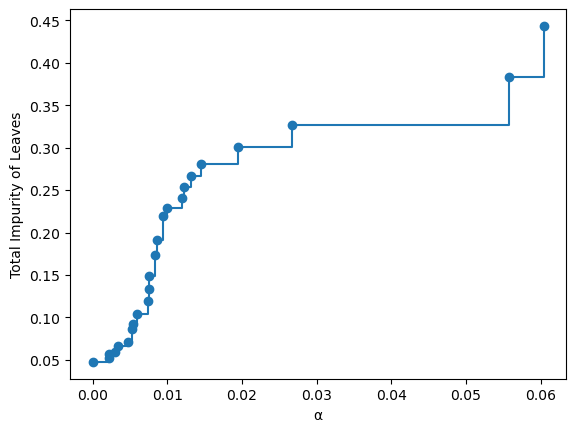

In [14]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
plt.xlabel('α')
plt.ylabel('Total Impurity of Leaves')
plt.savefig('figures/cost_complexity_pruning_path.pdf')

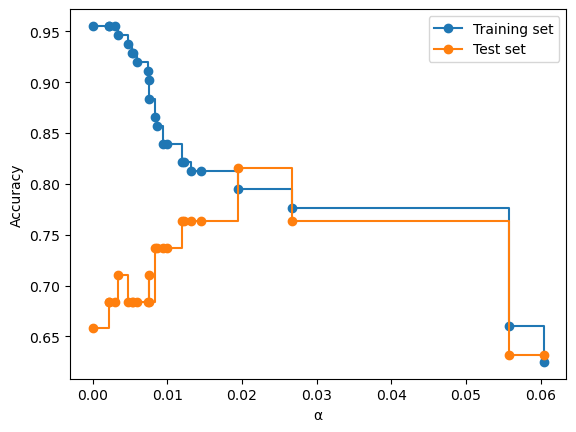

In [15]:
ccp_alphas = ccp_alphas[:-1]
train_scores, test_scores = [], []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.xlabel('α')
plt.ylabel('Accuracy')
plt.plot(ccp_alphas, train_scores, marker='o', label='Training set', drawstyle='steps-post')
plt.plot(ccp_alphas, test_scores, marker='o', label='Test set', drawstyle='steps-post')
plt.legend()
plt.savefig('figures/cost_complexity_pruning_accuracy.pdf')